In [1]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
from pyfinance import TSeries


In [3]:
from hurst import compute_Hc, random_walk

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In [5]:
def ShannonReallyFast(shannon_df):
    #print(shannon_df, 'suka')
    patterns = {'000', '001', '010', '100', '101', '110', '011', '111'}
    shannon_df = pd.DataFrame(shannon_df.copy(), columns=['returns'])
    shannon_df['pattern1'] = np.sign(shannon_df[['returns']])
    shannon_df['pattern2'] = np.sign(shannon_df[['returns']].shift(1))
    shannon_df['pattern3'] = np.sign(shannon_df[['returns']].shift(2))
    shannon_df.dropna(inplace=True)
    shannon_df = shannon_df[(shannon_df.pattern1 != 0.0) & (shannon_df.pattern2 != 0.0) & (shannon_df.pattern3 != 0.0)]
    shannon_df['merged'] = shannon_df.pattern1.astype('str') + shannon_df.pattern2.astype('str') + shannon_df.pattern3.astype('str')
    shannon_df['merged'] = shannon_df['merged'].str.replace('.0', '')
    shannon_df['merged'] = shannon_df['merged'].str.replace('-1', '0')
    prob_df = shannon_df.groupby('merged').count()['returns']
    pattern_df = pd.DataFrame(patterns).set_index(0).sort_values(by=0)
    #prob_df = prob_df.drop(index='111')
    pattern_df = pattern_df.join(prob_df).fillna(0)
    
    ProbSum = 0.0
    for pattern in patterns:
        
        p = pattern_df.loc[pattern] / pattern_df.returns.sum()      
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    
    return Shannon_val
    

def ShannonFast(df):
    # wrong pattern match
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.shift(1).dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df_):
    
    m = np.median(df_) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df_)-1):
        Pt = df_[i]
        Py = df_[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df_)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = 50+100*(pp+pm-mp-mm)/(pp + pm + mp+ mm)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



In [6]:
def generateRWI2(df):
    MomVal = Momersion(df['returns']) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df[['price']])
    h2 =  hurstF2(df[['price']])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1[0], h2[0], h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

In [7]:
### generate and stitch dataset

In [8]:
def generate_features(df):
    
    
    df['returns'] = np.log(df['price']).pct_change(1)
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] = np.abs( np.log(np.abs(df['price'].copy())).pct_change())
    

    df = df.replace([np.inf, -np.inf], np.nan)
    
    
    
    return df

In [9]:
def transform_series(tmp):
    #tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
    df = pd.DataFrame(np.asarray(tmp)+100)
    scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    df_ = scaler.fit_transform(df)
    df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
    df = (100+df_*100)
    return df

In [10]:
main = pd.read_csv('btc hourly dataset/Bitfinex_BTCUSD_1h-3.csv')

In [11]:
main['Date'] = pd.to_datetime(main['Date'],  format='%Y-%m-%d %I-%p')
main = main.sort_values(by='Date').set_index('Date')
main = main.resample('5h').mean().drop_duplicates()

In [12]:

main['range'] = 100*(main['High'] - main['Low'])/main['Low']
main['adj_close'] = main['Close'] / (main['High']*0.5 + main['Low']*0.5)
main['adj_close'] = main['adj_close'].replace([np.inf, -np.inf, 0], 0)
main = main.rename(columns={'Close':'price'})


In [278]:
"""
import ta
main['atr_14'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=14, fillna=True)
main['atr_50'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=50, fillna=True)
main['atr_5'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=5, fillna=True)
main['atr_500'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=5, fillna=True)
"""

'\nimport ta\nmain[\'atr_14\'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=14, fillna=True)\nmain[\'atr_50\'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=50, fillna=True)\nmain[\'atr_5\'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=5, fillna=True)\nmain[\'atr_500\'] = ta.volatility.average_true_range( high=main["High"], low=main["Low"], close=main["price"], n=5, fillna=True)\n'

In [279]:
#main_ta = ta.add_all_ta_features(df = main, open="Open", high="High", low="Low", close="price", volume="Volume USD", fillna=True)

In [14]:

main = main.drop(columns=['Volume BTC']).rename(columns={'Volume USD':'volume'})
main['volume_sma_5' ] = main['volume'].rolling(5).mean()
main['volume_sma_20' ] = main['volume'].rolling(20).mean()
main['volume_sma_50' ] = main['volume'].rolling(50).mean()
main['volume_sma_500' ] = main['volume'].rolling(500).mean()

main['volume_roc' ] = main['volume'].pct_change().fillna(0)
main['volume_roc_5' ] = main['volume'].pct_change(5).fillna(0)
main['volume_roc_20' ] = main['volume'].pct_change(20).fillna(0)
main['volume_roc_50' ] = main['volume'].pct_change(50).fillna(0)
main['volume_roc_500' ] = main['volume'].pct_change(500).fillna(0)





In [15]:
main['returns'] = main.price.pct_change().fillna(0)
main['hurst'] = main[['returns']].rolling(500).apply(hurstF4, raw=False) #.plot()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019704224710>,
      dtype=object)

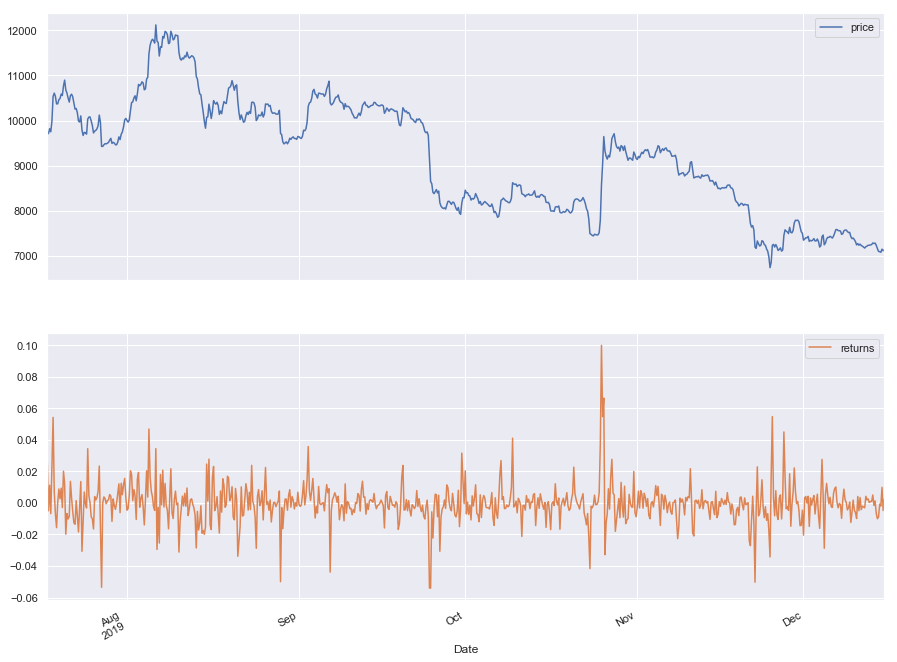

In [16]:
main.iloc[3100:][['price', 'returns']].plot(subplots=(2,1), figsize=(15,12))

In [17]:
autoCorrel(main.loc['2019-12-10':]['returns'], 20)

-0.17760952366128865

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000197045AA6D8>,
      dtype=object)

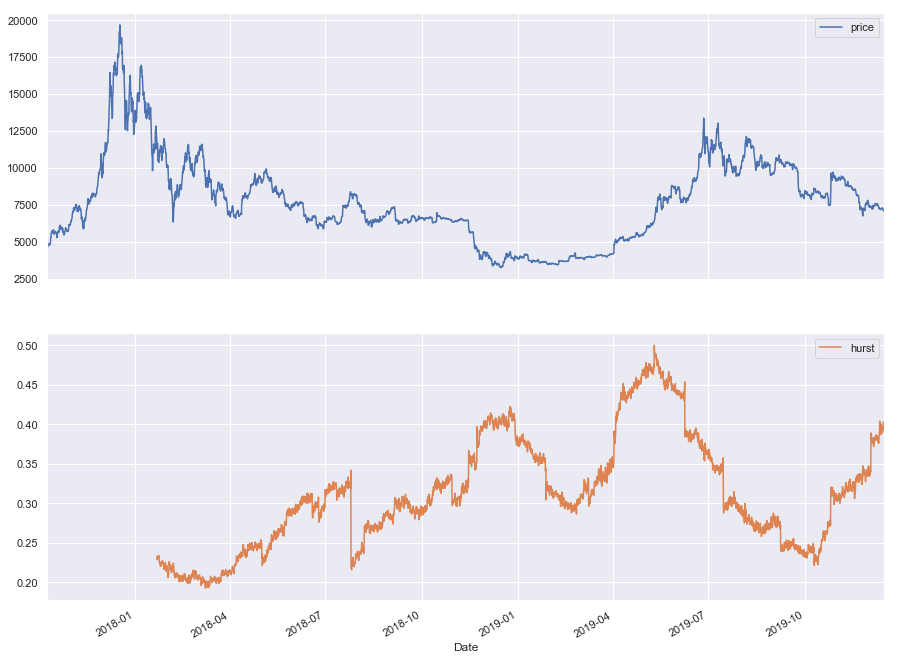

In [18]:
main[['price' ,'hurst']].plot(figsize=(15,12), subplots=(2,1))

In [24]:
main=main.drop(columns=['Open', 'High', 'Low'])

KeyError: "['Open' 'High' 'Low'] not found in axis"

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [26]:
main['month'] = main.index.month
main['day'] = main.index.day
main['hour'] = main.index.hour

In [27]:
selected_features = ['volume',
 'range',
 'adj_close',
 'volume_sma_5',
 'volume_roc',
 'volume_roc_5',
 'volume_roc_20',
 'volume_roc_50',
 'volume_roc_500',
 'returns',
 'ROC_2',
 'ROC_3',
 'ROC_5',
 'ROC_20',
 'ROC_50',
 'ROC_100',
 'ROC_200',
 'ROC_500',
 'abs_returns']

In [28]:
main.columns.tolist()

['price',
 'volume',
 'range',
 'adj_close',
 'volume_sma_5',
 'volume_sma_20',
 'volume_sma_50',
 'volume_sma_500',
 'volume_roc',
 'volume_roc_5',
 'volume_roc_20',
 'volume_roc_50',
 'volume_roc_500',
 'returns',
 'hurst',
 'month',
 'day',
 'hour']

In [29]:

df=main.copy()
df = df.replace([np.inf, -np.inf],0).fillna(0)
res = generate_features(df)

In [30]:
res.shape

(3826, 27)

In [31]:
3826 * 0.7

2678.2

In [32]:
3826-382

3444

In [33]:
X.shape

NameError: name 'X' is not defined

In [41]:

results = []
df = res.drop_duplicates().copy()
df.loc[:,'shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, :-1]
#X = X[selected_features]
rwi_list = generateRWI2(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train =X.iloc[0:2678]
y_train = y[0:2678]
X_test = X.iloc[3000:]
y_test = y.iloc[3000:]

clf = RandomForestClassifier(n_estimators=1000, max_depth=1000,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

rwi_list.append(score)
results.append(rwi_list)


D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [42]:
score

0.5846153846153846

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


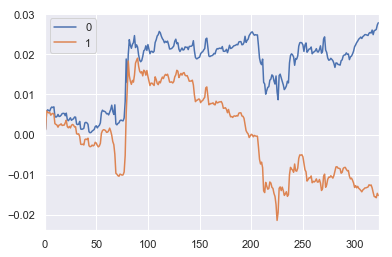

In [43]:
X_test['shift_returns'] = X['returns'].shift(-1)
a = pd.Series(y_pred)* X_test.shift_returns.abs().values 
b = y_test.shift_returns.values * X_test.shift_returns.abs().values 
pd.concat([pd.Series(a),pd.Series(b)], axis=1).cumsum().plot()

In [44]:
model = SelectFromModel(clf, prefit=True, threshold='mean')
X_new = model.transform(X)
X_new.shape  

(3325, 10)

In [45]:
X.loc[:,model.get_support()].columns.tolist()

['adj_close',
 'volume_roc',
 'volume_roc_5',
 'volume_roc_50',
 'volume_roc_500',
 'returns',
 'ROC_2',
 'ROC_3',
 'ROC_5',
 'ROC_20']

In [46]:
score

0.5846153846153846

In [47]:
# r, r, Mean-Reversal, random, trend, random

In [48]:
cols = ['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop', 'var_std', 'var_mean', 'var_median',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,   'score']
accuracy_df = pd.DataFrame(results, columns=cols) #.corr(method='spearman')['score'].sort_values()

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
accuracy_df.T

,0
MomVal,0.553851
MomDouble,60.776641
h1,0.520559
h2,0.492855
h3,0.578003
h4,0.514112
MMIR,0.712996
MMIP,0.510229
ShannonVal,2.978539
prop,51.488722


In [167]:
# accuracy closer to prop, MomVal, h4
#### Rolling husrt
### apply machine learning for accuracy detection

In [85]:
main.drop(columns=['score_100', 'score_200', 'score_500', 'score_800', 'score_1100', 'score_2000', 'score_50'],inplace=True)

KeyError: "['score_500' 'score_800' 'score_1100' 'score_2000'] not found in axis"

In [307]:
main = main[main.returns!=0.0]



In [315]:
# windowing
scores_list = []
for size in [50 , 100, 200,  500, 800, 1100, 2000, 3000]: # 
    
    total_length = main.shape[0]

    parts =  int(total_length/size)

    i = 0
    i2 = size
    results = []
    df2 = main.copy()
    for x in range(0,parts+1):

        #print(x, parts, i, i2, len(X_test))
        res = generate_features(main).fillna(0)
        
        df = res.iloc[i:i2].copy()    
        

        df['shift_returns'] = df['returns'].shift(-1).fillna(0)

        
        y = df.iloc[:, -1].copy()
        y = np.sign(y)
        X = df.iloc[:, :-1].copy()

        ###
        #print(size, i, i2)
        X = X.reset_index(drop=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        
        #print('division:',0, size*0.8)
        X_train =X[0:int(size*0.80)]
        y_train = y[0:int(size*0.80)]

        X_test = X[int(size*0.80)+5:]
        y_test = y[int(size*0.80)+5:]

        clf = RandomForestClassifier(n_estimators=500, max_depth=200,
                                     random_state=0)
        clf.fit(X_train, y_train)
        if (len(X_test)==0):
            print(x)
            break
        y_pred = clf.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        #print(score)
        ###
        
        main.loc[i:i2, 'score_'+str(size)] = score * 100
        
        i = i+size
        i2 = i2+ size
        scores_list.append((size, score*100))
        

    

76
38
19
7
4
3
1


In [316]:
pd.DataFrame([X.columns,clf.feature_importances_]).T.sort_values(by=1)

,0,1
31,score_3000,0
30,score_2000,0
28,score_800,0.00192466
29,score_1100,0.00193605
27,score_500,0.00257424
26,score_200,0.00494963
25,score_100,0.00669506
15,month,0.00837758
24,score_50,0.00847092
16,day,0.0323929


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2E0636240>,
      dtype=object)

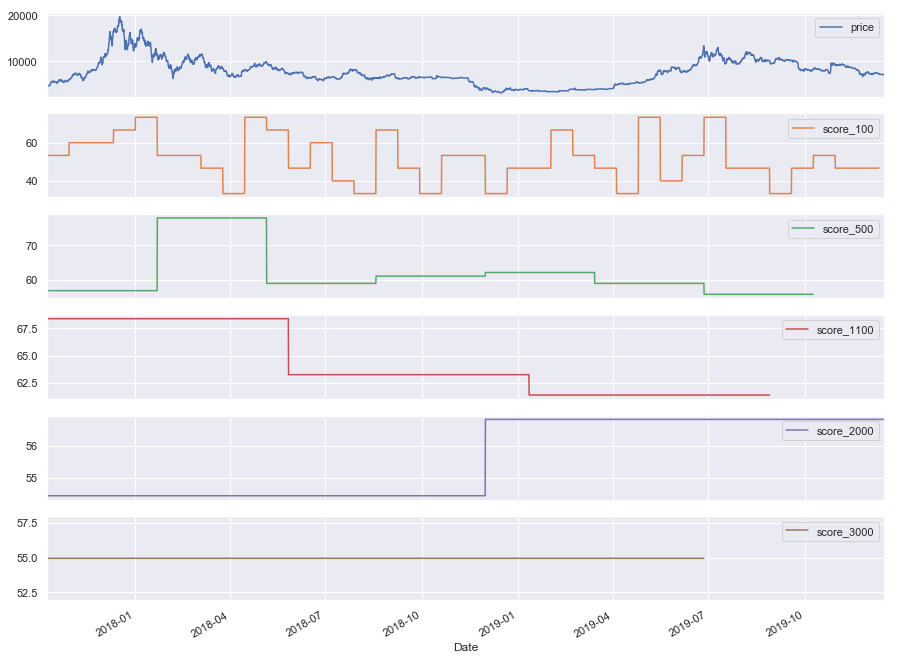

In [318]:
main[['price','score_100', 'score_500', 'score_1100', 'score_2000', 'score_3000']].plot(figsize=(15,12) , subplots=(2,1) ) # 

In [314]:
main[['price','score_100', 'score_500', 'score_1100', 'score_2000', 'score_3000']].mean()

price         7721.487722
score_100       52.280702
score_500       61.353383
score_1100      63.410853
score_2000      57.558158
score_3000      55.462185
dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E1A6F2BB00>,
      dtype=object)

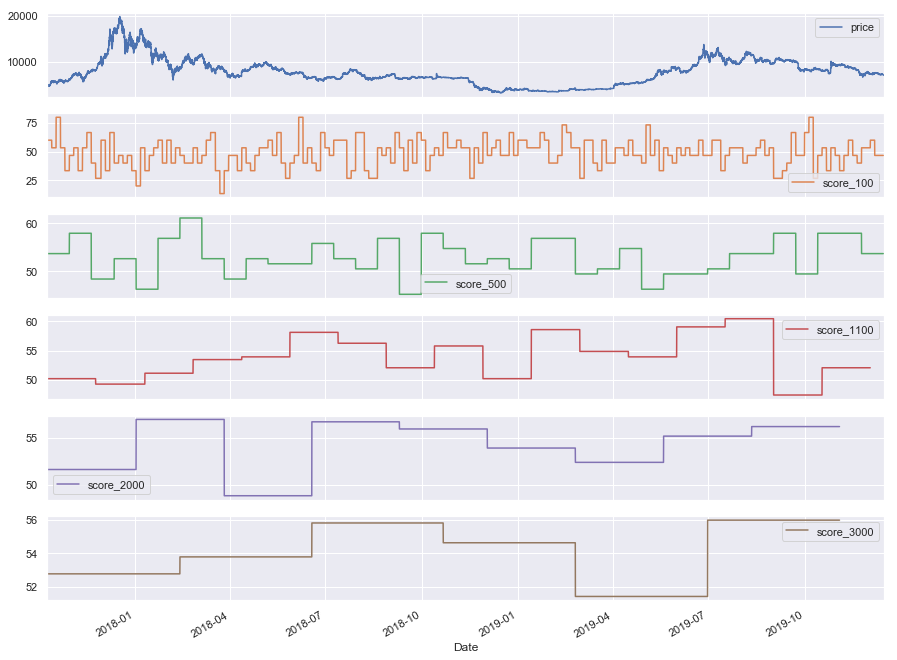

In [159]:
main[['price','score_100', 'score_500', 'score_1100', 'score_2000', 'score_3000']].plot(figsize=(15,12) , subplots=(2,1) ) # 

In [165]:
main[['price','score_100', 'score_500', 'score_1100', 'score_2000', 'score_3000']].drop_duplicates().mean() 

price         7723.599426
score_100       48.842079
score_500       52.899026
score_1100      53.944327
score_2000      54.201524
score_3000      54.061160
dtype: float64

In [174]:
main['score_3000'].drop_duplicates().median()

54.20168067226891

In [175]:
main['score_2000'].drop_duplicates().median()

55.18987341772152

In [152]:
main['score_100'].drop_duplicates().median()

46.666666666666664

In [153]:
main['score_500'].drop_duplicates().median()

52.63157894736842

In [154]:
main['score_1100'].drop_duplicates().median()

54.418604651162795

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7A3DB2908>,
      dtype=object)

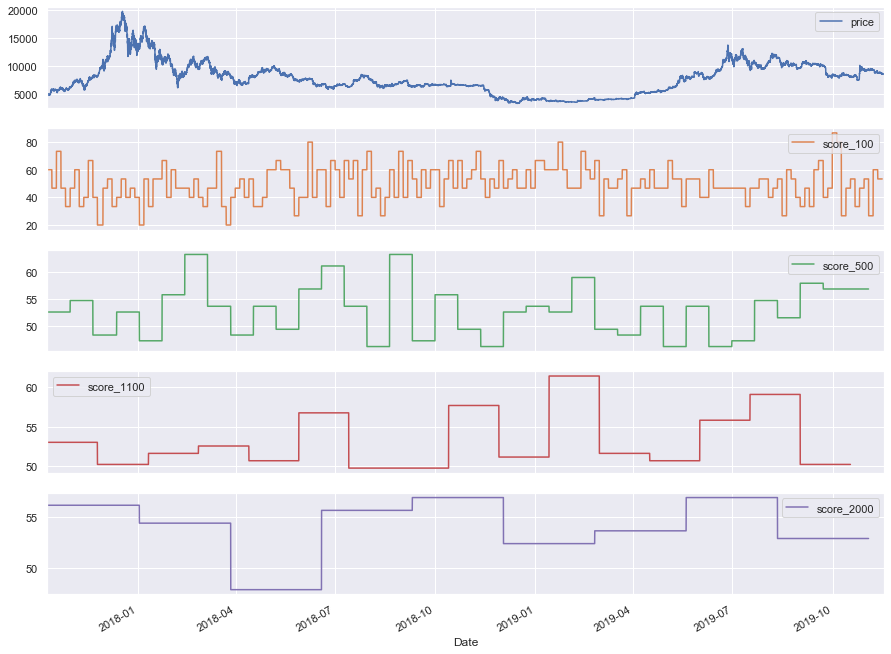

In [45]:
main[['price','score_100', 'score_500', 'score_1100', 'score_2000']].plot(figsize=(15,12) , subplots=(2,1) ) # 

In [176]:
main[['returns','score_100', 'score_500', 'score_1100']].rolling(300).mean().mean()

returns        0.000002
score_100     48.758652
score_500     52.896186
score_1100    53.998835
dtype: float64

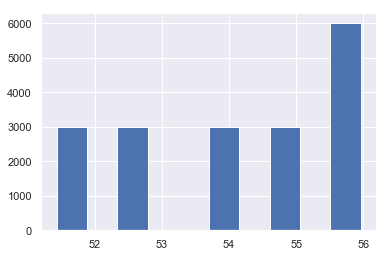

In [178]:
main.score_3000.hist()

In [185]:
accuracy_cols = ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100', 'score_2000']

In [186]:
import time

In [235]:
from sklearn.preprocessing import StandardScaler

In [290]:
scaler = StandardScaler()

In [317]:
# combining with accuracy 100 period momentum best result
res = generate_features(main).fillna(0)
#res = main
main = main.replace([np.inf, -np.inf], 0).fillna(0)
res = pd.DataFrame(scaler.fit_transform(main), index=main.index, columns=main.columns ) # 

size = res.shape[0]
#res.loc[:, ['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']]=res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)
#tmp = res[['score_50', 'score_100', 'score_200', 'score_500', 'score_800', 'score_1100']].pct_change(1).fillna(0)

#diff = res[accuracy_cols] - res[accuracy_cols].rolling(8).mean().fillna(method='bfill')
#roc = res[accuracy_cols].rolling(8).mean().fillna(method='bfill').pct_change(5).fillna(0)

#res = res.join(tmp.add_prefix('_roc1'))
#res = res.join(diff.add_prefix('_diff'))
#res = res.join(roc.add_prefix('_roc'))

df = res.copy()    
df = df.replace([np.inf, -np.inf],0).fillna(0)

df['shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()

y = df.iloc[:, -1].copy()
y = np.sign(y)
X = df.iloc[:, :-1].copy()
X = X.fillna(0)

random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)
#print('division:',0, size*0.8)
X_train =X.iloc[0:int(size*0.80)]
y_train = y.iloc[0:int(size*0.80)]

X_test = X.iloc[int(size*0.80)+5:size]
y_test = y.iloc[int(size*0.80)+5:size]

clf = RandomForestClassifier(n_estimators=1000, max_depth=200,
                             random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [318]:
score

0.5572519083969466

In [319]:
X_test['hurst_500']=X_test['price'].rolling(500).apply(hurstF4).fillna(50)
X_test['hurst_2000']=X_test['price'].rolling(2000).apply(hurstF4).fillna(50)

In [320]:

X_test['momersion_500'] = X_test[['returns']].rolling(500).apply(Momersion, raw=False).fillna(0.50)
X_test['momersion_100'] = X_test[['returns']].rolling(100).apply(Momersion, raw=False).fillna(0.50)


In [321]:
X_test

,price,volume,range,adj_close,volume_sma_5,volume_sma_20,volume_sma_50,volume_sma_500,volume_roc,volume_roc_5,...,score_200,score_500,score_800,score_1100,score_2000,score_3000,hurst_500,hurst_2000,momersion_500,momersion_100
15222,1.695448,0.420475,0.348760,0.901919,-0.006961,0.183056,0.022553,0.263591,-0.134882,-0.018101,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15223,1.694040,-0.214634,-0.146234,-0.016063,0.037806,0.170256,0.025366,0.264117,-0.262160,-0.021816,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15224,1.705655,-0.187921,-0.241951,-0.081801,0.057340,0.152059,0.027557,0.264349,-0.123350,-0.040653,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15225,1.678554,0.404287,1.173890,0.481101,0.200203,0.186746,0.032533,0.266741,0.133367,-0.001759,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15226,1.643006,-0.110839,0.310448,-0.132460,0.075162,0.203654,0.038367,0.267407,-0.239929,-0.065799,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15227,1.702135,0.089961,0.860211,0.834166,-0.003635,0.176490,0.043156,0.269110,-0.057725,-0.059234,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15228,1.708823,-0.226509,0.074830,0.700515,-0.006466,0.108163,0.042145,0.270177,-0.226741,-0.049200,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15229,1.702487,-0.340868,-0.221583,-0.122905,-0.042930,0.066377,0.046314,0.270905,-0.192973,-0.059923,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15230,1.816875,1.322731,1.397496,2.629213,0.176035,0.172174,0.092193,0.276677,0.987291,-0.017214,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000
15231,1.826378,0.293136,-0.112788,-0.216256,0.272346,0.203409,0.116062,0.279449,-0.247351,-0.021727,...,1.362115,-0.559736,-0.136690,0.769475,0.312275,0.391308,50.000000,50.000000,0.500000,0.500000


In [322]:
cols = ['score_50', 'score_100', 'score_200', 'score_500', 'score_2000', 'hurst_500', 'hurst_2000', 'momersion_500', 'momersion_100', 'volume_sma_5', 'volume_sma_50', 'volume_sma_500', 'volume_roc_5', 'volume_roc_50', 'volume_roc_500', 'volume' ] # , 'atr_5', 'atr_50', 'atr_500'

In [297]:
cols = ['volume_sma_5', 'volume_sma_50', 'volume_sma_500', 'volume_roc_5', 'volume_roc_50', 'volume_roc_500', 'volume' ] # , 'atr_5', 'atr_50', 'atr_500'

In [323]:
b = pd.DataFrame(list(zip(y_test, y_pred)))
trading_df = X_test[cols].reset_index(drop=True).join(b)
trading_df = trading_df.rename(columns={0:'actual', 1:'predicted'})
trading_df['profit'] = trading_df.actual * trading_df.predicted
trading_df.profit.cumsum().pct_change(3).replace([np.inf, -np.inf],0).fillna(0).mean()*252 / (trading_df.profit.cumsum().pct_change(3).replace([np.inf, -np.inf],0).fillna(0).std() * np.sqrt(252))

1.0395026436373769

In [324]:
trading_df['profit_shift_2'] =trading_df['profit'].shift(1)
trading_df['profit_shift_3'] =trading_df['profit'].shift(2)


In [325]:
trading_df.dropna(inplace=True)

In [326]:
trading_df['profit_cum'] = trading_df.profit + trading_df.profit_shift_2 + trading_df.profit_shift_3

In [327]:
trading_df.drop(columns='actual', inplace=True)

In [328]:
df.columns

Index(['price', 'volume', 'range', 'adj_close', 'volume_sma_5',
       'volume_sma_20', 'volume_sma_50', 'volume_sma_500', 'volume_roc',
       'volume_roc_5', 'volume_roc_20', 'volume_roc_50', 'volume_roc_500',
       'returns', 'hurst', 'month', 'day', 'hour', 'ROC_2', 'ROC_3', 'ROC_5',
       'ROC_20', 'ROC_50', 'ROC_100', 'ROC_200', 'ROC_500', 'abs_returns',
       'score_50', 'score_100', 'score_200', 'score_500', 'score_800',
       'score_1100', 'score_2000', 'score_3000', 'shift_returns'],
      dtype='object')

In [329]:
df = trading_df.sample(400, random_state=0).reset_index(drop=True)
df.drop(columns=['profit', 'profit_shift_2', 'profit_shift_3'], inplace=True)
df['profit_cum'] = df['profit_cum'].shift(-1)

df = df.replace([np.inf, -np.inf], 0).dropna()
X = df.iloc[:, 0:-1]

X.loc[:, cols] =  pd.DataFrame( scaler.fit_transform(X.loc[:, cols]), index=X.index, columns=X.loc[:, cols].columns ) 


In [330]:
df

,score_50,score_100,score_200,score_500,score_2000,hurst_500,hurst_2000,momersion_500,momersion_100,volume_sma_5,volume_sma_50,volume_sma_500,volume_roc_5,volume_roc_50,volume_roc_500,volume,predicted,profit_cum
0,-1.203594,-0.115854,0.161705,-0.125014,-1.610573,-0.382151,-1.090889,-0.388810,-1.958116,0.260832,-0.525468,-0.634366,-0.403310,0.088376,0.206879,-0.330068,-1.0,1.0
1,1.742627,-0.115854,-0.224643,-0.125014,0.592668,-0.387023,0.915811,-0.721717,-0.870879,-0.160206,0.350678,0.231792,-0.290373,-0.393825,-0.301021,-0.368349,-1.0,-1.0
2,1.742627,0.469282,0.161705,-0.125014,0.633094,-0.384922,0.915811,-0.638490,1.303594,0.245977,1.431489,0.284642,-0.468729,-0.379301,-0.251292,-0.314966,-1.0,-1.0
3,-0.221520,-0.115854,1.320748,-0.772813,0.592668,2.583216,0.915811,2.232839,-0.001090,2.284081,2.885805,2.790943,-0.332928,-0.103869,-0.302663,1.585437,1.0,3.0
4,-2.185668,-0.115854,0.934400,0.738718,0.633094,-0.393900,-1.091646,0.609914,-0.218537,-0.521172,-0.830809,-0.642086,0.528359,-0.078754,-0.365373,-0.011487,-1.0,3.0
5,-0.221520,1.054418,1.707096,-0.772813,0.592668,2.583216,0.915811,2.232839,1.412318,1.192344,4.317834,3.315283,-0.181791,-0.065551,-0.213715,1.895679,-1.0,1.0
6,-1.203594,-1.286126,1.707096,-0.772813,0.592668,2.583216,0.915811,2.232839,0.651252,1.405953,2.533047,3.147492,-0.315463,-0.123425,-0.156606,0.486936,1.0,1.0
7,-1.203594,0.469282,1.320748,-0.125014,0.592668,2.583216,0.915811,2.232839,-0.435985,-0.427869,0.454222,2.149323,-0.344714,-0.214083,-0.291200,-0.222734,-1.0,3.0
8,0.760553,0.469282,-0.224643,-0.125014,-1.610573,-0.379331,-1.091250,0.193779,0.433805,1.033551,-0.133235,-0.692507,-0.336041,-0.146559,1.754703,-0.098594,-1.0,3.0
9,0.760553,-1.871261,0.548052,0.738718,0.633094,-0.387407,0.915811,-0.055902,1.086147,-0.745434,-0.796785,-0.230965,-0.443265,-0.362716,-0.356688,-0.544950,-1.0,1.0


In [331]:
y = np.sign(df.iloc[:,-1]) #.astype('category').cat.codes

In [332]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [333]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=300,
                             random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [334]:
from sklearn.metrics import confusion_matrix

In [335]:
score

0.5875

In [336]:
confusion_matrix(y_test, y_pred)

array([[ 5, 23],
       [10, 42]], dtype=int64)

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 65.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

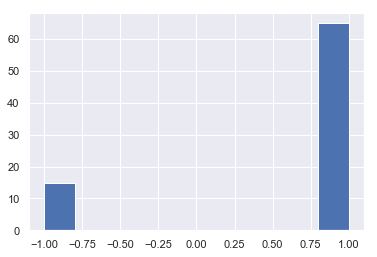

In [337]:
plt.hist(y_pred)

In [338]:
y_test.reset_index(drop=True).cumsum()

0     -1.0
1      0.0
2      1.0
3      0.0
4      1.0
5      2.0
6      3.0
7      2.0
8      3.0
9      2.0
10     3.0
11     2.0
12     3.0
13     4.0
14     5.0
15     6.0
16     7.0
17     8.0
18     9.0
19    10.0
20     9.0
21    10.0
22     9.0
23     8.0
24     7.0
25     8.0
26     9.0
27     8.0
28     9.0
29     8.0
      ... 
50    13.0
51    14.0
52    15.0
53    16.0
54    17.0
55    18.0
56    19.0
57    20.0
58    21.0
59    20.0
60    19.0
61    20.0
62    21.0
63    22.0
64    23.0
65    22.0
66    21.0
67    22.0
68    21.0
69    20.0
70    21.0
71    22.0
72    21.0
73    22.0
74    23.0
75    24.0
76    23.0
77    24.0
78    23.0
79    24.0
Name: profit_cum, Length: 80, dtype: float64

In [339]:
pd.Series(y_pred).reset_index(drop=True).cumsum()

0      1.0
1      2.0
2      3.0
3      4.0
4      5.0
5      6.0
6      7.0
7      8.0
8      9.0
9     10.0
10    11.0
11    10.0
12    11.0
13    10.0
14     9.0
15    10.0
16     9.0
17     8.0
18     7.0
19     8.0
20     9.0
21    10.0
22    11.0
23    12.0
24    13.0
25    14.0
26    13.0
27    14.0
28    15.0
29    16.0
      ... 
50    29.0
51    30.0
52    31.0
53    32.0
54    33.0
55    34.0
56    35.0
57    34.0
58    35.0
59    34.0
60    35.0
61    34.0
62    35.0
63    36.0
64    37.0
65    38.0
66    39.0
67    40.0
68    41.0
69    42.0
70    43.0
71    44.0
72    43.0
73    44.0
74    45.0
75    46.0
76    47.0
77    48.0
78    49.0
79    50.0
Length: 80, dtype: float64

In [340]:
a = pd.Series(y_pred)

In [341]:
a[a==1].cumsum()

0      1.0
1      2.0
2      3.0
3      4.0
4      5.0
5      6.0
6      7.0
7      8.0
8      9.0
9     10.0
10    11.0
12    12.0
15    13.0
19    14.0
20    15.0
21    16.0
22    17.0
23    18.0
24    19.0
25    20.0
27    21.0
28    22.0
29    23.0
30    24.0
31    25.0
32    26.0
33    27.0
34    28.0
35    29.0
37    30.0
      ... 
44    36.0
45    37.0
46    38.0
49    39.0
50    40.0
51    41.0
52    42.0
53    43.0
54    44.0
55    45.0
56    46.0
58    47.0
60    48.0
62    49.0
63    50.0
64    51.0
65    52.0
66    53.0
67    54.0
68    55.0
69    56.0
70    57.0
71    58.0
73    59.0
74    60.0
75    61.0
76    62.0
77    63.0
78    64.0
79    65.0
Length: 65, dtype: float64

In [342]:
pd.DataFrame([X.columns,clf.feature_importances_]).T.sort_values(by=1)

,0,1
4,score_2000,0.00950944
3,score_500,0.0139658
16,predicted,0.015872
1,score_100,0.0276563
0,score_50,0.0277245
2,score_200,0.0307881
6,hurst_2000,0.0447773
7,momersion_500,0.0583872
8,momersion_100,0.0628539
5,hurst_500,0.0723743


In [329]:
"""
Let’s try using two calculations based off of a 10-period simple moving average (SMA) of our equity curve. 
We are going to look at both the rate of change over 5-periods and the distance between the current balance of the equity curve and the SMA line. 
The rate of change (ROC) should tell us if our equity curve is in a general downtrend and the distance between the lines should give us a much more sensitive measure of how the strategy is performing.
"""

'\nLet’s try using two calculations based off of a 10-period simple moving average (SMA) of our equity curve. \nWe are going to look at both the rate of change over 5-periods and the distance between the current balance of the equity curve and the SMA line. \nThe rate of change (ROC) should tell us if our equity curve is in a general downtrend and the distance between the lines should give us a much more sensitive measure of how the strategy is performing.\n'

In [330]:
score

0.4625

In [316]:
y_train

336   -1.0
64    -1.0
55     1.0
106    1.0
300    1.0
      ... 
323   -1.0
192   -1.0
117    1.0
47     1.0
172    1.0
Name: profit, Length: 320, dtype: float64

In [57]:
# Test with cumulative profit

In [223]:
df = trading_df.copy() #.sample(1000, random_state=0).reset_index(drop=True)

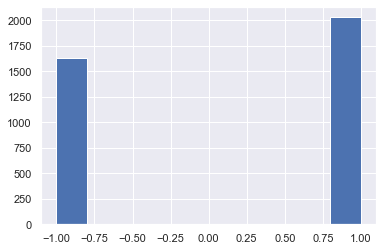

In [270]:
trading_df.profit.hist()

In [263]:
((trading_df['profit']).cumsum())

0         1.0
1         2.0
2         3.0
3         4.0
4         5.0
        ...  
3659    396.0
3660    397.0
3661    398.0
3662    399.0
3663    398.0
Name: profit, Length: 3664, dtype: float64

In [225]:
df['profit'].reset_index(drop=True).cumsum().tail()

3659    396.0
3660    397.0
3661    398.0
3662    399.0
3663    398.0
Name: profit, dtype: float64

In [226]:
df['cum_sum'] = df['profit'].reset_index(drop=True).cumsum()

In [227]:
df['cum_sum_roc'] = df['cum_sum'].pct_change().replace([np.inf, -np.inf],0).fillna(0)

In [228]:
df['cum_sum_roc5'] = df['cum_sum'].pct_change(50).replace([np.inf, -np.inf],0).fillna(0)

In [229]:
df.columns

Index(['score_50', 'score_100', 'score_200', 'score_500', 'score_2000',
       'hurst_500', 'hurst_2000', 'momersion_500', 'momersion_100', 'actual',
       'predicted', 'profit', 'cum_sum', 'cum_sum_roc', 'cum_sum_roc5'],
      dtype='object')

In [230]:
df.drop(columns=['actual', 'predicted','profit'], inplace=True)


In [231]:
df['class'] = np.sign(df['cum_sum_roc5'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7A6ED4AC8>]],
      dtype=object)

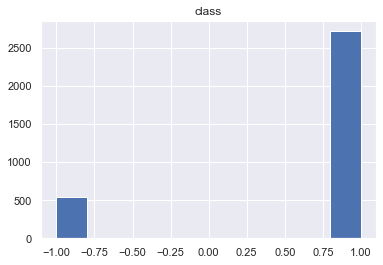

In [268]:
df[['class']].astype('int').hist()

In [232]:
df = df[df['class']!=0.0]
df['class'] = df['class'].astype('category')

In [233]:
X = df.drop(columns=['cum_sum', 'cum_sum_roc', 'cum_sum_roc5', 'class'])

In [234]:
y=df['class']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X = X.reset_index(drop=True)
#print('division:',0, size*0.8)

size = X.shape[0]
X_train =X.iloc[0:int(size*0.80)]
y_train = y.iloc[0:int(size*0.80)]

X_test = X.iloc[int(size*0.80):size]
y_test = y.iloc[int(size*0.80):size]

clf = RandomForestClassifier(n_estimators=1000, max_depth=100,
                             random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [236]:
score

0.6748466257668712

In [237]:
pd.DataFrame([X.columns,clf.feature_importances_]).T.sort_values(by=1)

,0,1
4,score_2000,0.0105847
2,score_200,0.0414942
3,score_500,0.0638378
0,score_50,0.068028
1,score_100,0.0803251
6,hurst_2000,0.133358
7,momersion_500,0.187989
8,momersion_100,0.193359
5,hurst_500,0.221024


In [351]:
df.corr()['score_2000'].sort_values()

volume_roc_500   -0.090783
volume_roc_5     -0.090523
score_500        -0.067351
volume_roc_50    -0.054234
score_200        -0.023518
predicted         0.000382
profit_cum        0.013757
score_100         0.028971
momersion_100     0.100912
volume            0.143075
score_50          0.148303
volume_sma_5      0.206760
hurst_500         0.228151
volume_sma_50     0.352186
momersion_500     0.357669
volume_sma_500    0.377848
hurst_2000        0.673378
score_2000        1.000000
Name: score_2000, dtype: float64

2000 score accuacy is better by average and median

all:
24
50
65

Only accuracy scores:
24
36
58
Best indicators: 200, 100


Momersion, 500, 100, hurst:
24
16
58


Only volume:
24
46
63
Accuracy 53


Conclusion:
Volume is superior
Scores on 2nd level
Combination is best case



In [222]:
y_test.shape

(161,)

In [187]:
y_test.shape

(63,)

In [188]:
score

0.9523809523809523

In [189]:
### practical application

In [343]:
trading_df['entry'] = clf.predict(trading_df[['score_50', 'score_100', 'score_200']])

ValueError: Number of features of the model must match the input. Model n_features is 17 and input n_features is 3 

In [191]:
trading_df[trading_df.entry==1]['profit'].cumsum().plot()

AttributeError: 'DataFrame' object has no attribute 'entry'

In [2164]:
# need to think how to split test and train dataset for practical purposes
# shift , we know market regive after trade completion
# rolling ML

In [1649]:
# https://docs.pymc.io/notebooks/GLM-rolling-regression.html
# https://pypi.org/project/pyfinance/
# https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html